# Generate annotations with Geolabel Maker &nbsp; [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/makinacorpus/geolabel-maker/blob/master/notebooks/Generate%20a%20dataset%20with%20Geolabel%20%Maker.ipynb)

A tutorial provided by [Makina Corpus](https://makina-corpus.com/)  

The notebook will guide you step by step on how to generate a dataset from scratch. In this tutorial, we will see how to create a ground truth from satellite imagery and vector geometries from data preparation to annotations. 

The necessary steps for the creation of this ground truth are:

**1. `labels`: Generate labels from satellite imagery and vector geometries**

**2. `mosaics` or `tiles`: Generate subsets of images at a specific zoom level**

**3. `annotations`: Generate the annotations from the satellite images and generated labels**

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Up

As always, we will load the required packages to generate a dataset. We will add ``geolabel_maker`` package to the path,
to make sure you can access its modules.  
As this notebook is available on google colaboratory, we need to load GDAL and other packages differently.

In [48]:
import sys
import os

RUN_ON_COLAB = False

# Check if its running from Colab
if "google.colab" in str(get_ipython()):
    RUN_ON_COLAB = True
    print("Running on Google Colab")
else:
    print("Running on Jupyter")

Running on Jupyter


### For Jupyter users

The following code will load packages for Notebook users. Keep in mind that GDAL and other packages must be installed.

In [49]:
if not RUN_ON_COLAB:
    sys.path.append("../")

### For Colab users

In [50]:
if RUN_ON_COLAB:
    # Install GDAL
    !apt install gdal-bin python-gdal python3-gdal 
    # Install rasterio
    !pip install rasterio
    # Install rtree (required by geopandas)
    !apt install python3-rtree 
    # Install geopandas
    !pip install git+git://github.com/geopandas/geopandas.git
    # Install geopandas (required by geopandas)
    !pip install descartes
    # Install GDAL2TILES
    !pip install gdal2tiles
    # Import SentinelSat from ESA Copernicus program
    !pip install sentinelsat
    # OSM to geojson converter
    !pip install osmtogeojson
    # Install OpenCV for fast segmentation
    !pip install opencv-python
    # Install Geolabel Maker
    !git clone -b projinfo-dev https://github.com/makinacorpus/geolabel-maker
    sys.path.append("/content/geolabel-maker")

    # Sanity check to know if GDAL is correctly installed.
    # SKipping this step may raise errors like:
    # CPLE_AppDefinedError: PROJ: proj_create from database: Cannot find proj.db

    import rasterio
    filename = "http://landsat-pds.s3.amazonaws.com/c1/L8/003/065/LC08_L1TP_003065_20190925_20191017_01_T1/LC08_L1TP_003065_20190925_20191017_01_T1_B4.TIF"
    rasterio.open(filename)

In [51]:
# Basic imports
from pathlib import Path
import requests
import json

# Geolabel Maker
from geolabel_maker import Dataset
from geolabel_maker.rasters import Raster, RasterCollection
from geolabel_maker.vectors import Category, CategoryCollection
from geolabel_maker.annotations import Segmentation, ObjectDetection, Classification

### Speedups

Some users can experience issues related to ``shapely``. To fix it, simply use ``speedups.disable()``

In [52]:
# Disable speedups for windows users because they can experience errors
if os.name == "nt":
    from geolabel_maker import speedups
    
    speedups.disable()

## Explore the data

In this section, we will download and visualize the satellite images and vectors used to generate the annotations.

We will download rasters from Lyon, published as open data in the website [https://data.grandlyon.com](https://data.grandlyon.com):

- [1843_5173_08_CC46.tif](https://download.data.grandlyon.com/files/grandlyon/imagerie/ortho2018/ortho/GeoTiff_YcBcR/1km_8cm_CC46/1843_5173_08_CC46.tif) from this [download page](https://data.grandlyon.com/jeux-de-donnees/orthophotographie-2018-metropole-lyon-format-tiff/donnees)
- [1844_5173_08_CC46.tif](https://download.data.grandlyon.com/files/grandlyon/imagerie/ortho2018/ortho/GeoTiff_YcBcR/1km_8cm_CC46/1844_5173_08_CC46.tif) from this [download page](https://data.grandlyon.com/jeux-de-donnees/orthophotographie-2018-metropole-lyon-format-tiff/donnees)

We will also place them in a root directory ``data/images``, to faciliate the use of Geolabel Maker.

![images](https://raw.githubusercontent.com/makinacorpus/geolabel-maker/projinfo-dev/notebooks/medias/lyon_images.png)

The categories can also be downloaded from [Lyon's website](https://data.grandlyon.com).

- [buildings.json](https://download.data.grandlyon.com/wfs/grandlyon?SERVICE=WFS&VERSION=2.0.0&request=GetFeature&typename=cad_cadastre.cadbatiment&outputFormat=application/json;%20subtype=geojson&SRSNAME=EPSG:4171) from this [download page](https://data.grandlyon.com/jeux-de-donnees/batiments-metropole-lyon/telechargements)
- [vegetation.json](https://download.data.grandlyon.com/wfs/grandlyon?SERVICE=WFS&VERSION=2.0.0&request=GetFeature&typename=com_donnees_communales.comparcjardin_1_0_0&outputFormat=application/json;%20subtype=geojson&SRSNAME=EPSG:4171) from this [download page](https://data.grandlyon.com/jeux-de-donnees/parcs-jardins-metropole-lyon/telechargements)
- [bridges.json](https://download.data.grandlyon.com/wfs/grandlyon?SERVICE=WFS&VERSION=2.0.0&request=GetFeature&typename=fpc_fond_plan_communaut.fpcpont&outputFormat=application/json;%20subtype=geojson&SRSNAME=EPSG:4171) from this [download page](https://data.grandlyon.com/jeux-de-donnees/ponts-metropole-lyon/telechargements) (optional)

![categories](https://raw.githubusercontent.com/makinacorpus/geolabel-maker/projinfo-dev/notebooks/medias/lyon_categories.png)

First, let's create a function that will download all the data.

In [53]:
def download_image(url, out_file):
    """Download data from an url.
    
    Args:
        url (str): URL used to request data.
        out_file (str): Name of the output file.
    """
    Path(out_file).parent.mkdir(parents=True, exist_ok=True)
    with open(out_file, "wb") as handle:
        response = requests.get(url, stream=True)
        for block in response.iter_content(1024):
            if not block:
                break
            handle.write(block)
    

def download_vector(url, out_file):
    """Download vector from an url.
    
    Args:
        url (str): URL used to request data.
        out_file (str): Name of the output file.
    """
    Path(out_file).parent.mkdir(parents=True, exist_ok=True)
    with open(out_file, "w") as handle:
        response = requests.get(url, stream=True)
        json.dump(response.json(), handle)

### Download images

Then, we will download the images and save them under ``data/images`` directory.

In [54]:
# Download 1843_5173_08_CC46 tile
url = "https://download.data.grandlyon.com/files/grandlyon/imagerie/ortho2018/ortho/GeoTiff_YcBcR/1km_8cm_CC46/1843_5173_08_CC46.tif"
download_image(url, out_file="data/images/1843_5173_08_CC46.tif")

# Download 1844_5173_08_CC46 tile
url = "https://download.data.grandlyon.com/files/grandlyon/imagerie/ortho2018/ortho/GeoTiff_YcBcR/1km_8cm_CC46/1844_5173_08_CC46.tif"
download_image(url, out_file="data/images/1844_5173_08_CC46.tif")

### Download vectors

We do the same for the vectors, except we save them under ``data/categiries`` directory.

In [55]:
# Download buildings
url = "https://raw.githubusercontent.com/makinacorpus/geolabel-maker/projinfo-dev/data/categories/buildings.json"
download_vector(url, out_file="data/categories/buildings.json")

# Download vegetation
url = "https://raw.githubusercontent.com/makinacorpus/geolabel-maker/projinfo-dev/data/categories/vegetation.json"
download_vector(url, out_file="data/categories/vegetation.json")

### Open the data

Once downloaded, we can open the data using ``Raster`` and ``Category`` classes from ``geolabel-maler``.
These classes heavily depends on ``rasterio`` and ``geopandas``. 

#### Open rasters

To open a raster, use the `open` method. You will need to provide the path to the file you want to open.

In [56]:
image = Raster.open("data/images/1843_5173_08_CC46.tif")
image

Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)

Alternatively, you can load all rasters together with a ``RasterCollection``:

In [57]:
images = RasterCollection(image)
images

RasterCollection(
  (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
)

Or you can load directly the rasters from their file name:

In [58]:
images = RasterCollection.open(
    "data/images/1843_5173_08_CC46.tif", 
    "data/images/1844_5173_08_CC46.tif"
)
images

Loading: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 52.63it/s]


RasterCollection(
  (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
  (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
)

... or from directories:

In [59]:
images = RasterCollection.from_dir("data/images", pattern="*.tif")
images

Loading: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 51.29it/s]


RasterCollection(
  (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
  (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
)

#### Open vectors

In ``geolabel-maker``, vectors are often called categories. The difference is that a category must have a name and color.

To open a category use the `open` method. You can provide optional arguments such as `name` and `color`.

In [60]:
buildings = Category.open("data/categories/buildings.json", name="buildings", color="#92a9a2")
buildings

Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)

In [61]:
vegetation = Category.open("data/categories/vegetation.json", name="vegetation", color="green")
vegetation

Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(0, 128, 0), crs=EPSG:3946)

You can load all categories together with a ``CategoryCollection``.

In [62]:
categories = CategoryCollection(vegetation, buildings)
categories

CategoryCollection(
  (0): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(0, 128, 0), crs=EPSG:3946)
  (1): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)
)

If you create a collection from file names directly, you won't be able to set their color. Random ones will be generated:

In [63]:
CategoryCollection.open(
    "data/categories/buildings.json",
    "data/categories/vegetation.json"
)

Loading: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]


CategoryCollection(
  (0): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(143, 172, 190), crs=EPSG:3946)
  (1): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(202, 57, 112), crs=EPSG:3946)
)

In [64]:
CategoryCollection.from_dir("data/categories", pattern="*.json")

Loading: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.52s/it]


CategoryCollection(
  (0): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(124, 237, 226), crs=EPSG:3946)
  (1): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(240, 59, 113), crs=EPSG:3946)
)

You may experience errors using `geopandas` and `pyproj`. For example, on Google Colab the CRS is incorrectly retrieved, and must be set manually.

In [65]:
if RUN_ON_COLAB:
    categories[0].data = categories[0].data.set_crs("EPSG:3946", allow_override=True)
    categories[1].data = categories[1].data.set_crs("EPSG:3946", allow_override=True)

### Visualize the data

You can plot the data using ``plot`` methods. You can either plot the full data or only its bound, which is faster.

<AxesSubplot:title={'center':'CategoryCollection'}>

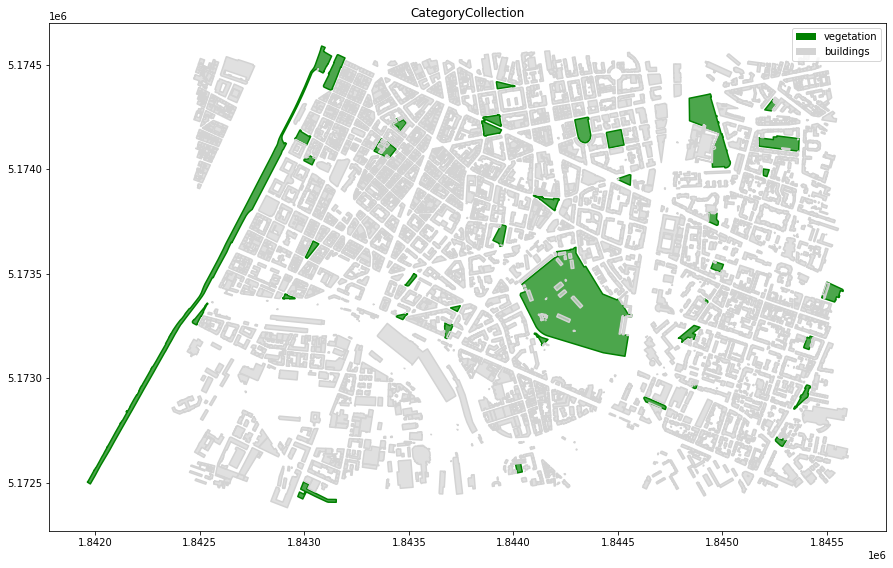

In [66]:
categories.plot(figsize=(15, 15))

## Generate labels

Once you have your data, you can initialize a dataset. A ``Dataset`` is an object that contains your aerial or satellite images and a set of categories stored in the attributes ``images`` and ``categories`` respectively. This object will be used to generate labels (a.k.a masks from the categories), stored on disk and / or in its ``labels`` attribute. In addition this class is used to create tiles or mosaics from bigger images / labels.

### Open a dataset

You can create one directly using loaded rasters and categories collection. To keep track of our modification troughout the entire process, it is recommended to provide a ``filename`` to a ``Dataset``: it will keep track of all the variables used to generate the labels.

There are different approaches to open a dataset. 

1. Directly from images or categories;
2. From a configuration file;
3. From images / categories / labels directories;
4. From a root folder.

In [67]:
dataset = Dataset(images=images, categories=categories, filename="data/dataset.json")
dataset

Dataset(
  (root): 'data'
  (filename): 'data\dataset.json'
  (images): RasterCollection(
    (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
    (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
  )
  (categories): CategoryCollection(
    (0): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(0, 128, 0), crs=EPSG:3946)
    (1): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)
  )
)

Notice that a ``dataset.json`` file should appear once the dataset is loaded. This file corresponds to the configuration of the dataset.
To control this behavior use the argument ``filename``:

```python
Dataset(images=images, categories=categories, filename="save/your/configuration/here/config.json")
```

You can provide a minimal configuration mapping images and categories directories such as:

```json
{
    "dir_images": "images",
    "dir_categories": "categories"
}
```

Or, you can specify manually each paths with an advanced configuration:

```json
{
    "images": [
        {
            "id": 0,
            "filename": "some/directory/1842_5174_08_CC46.tif"
        },
        {
            "id": 1,
            "filename": "other/directory/1842_5175_08_CC46.tif"
        }
    ],
    "categories": [
        {
            "id": 0,
            "name": "vegetation",
            "color": "green",
            "filename": "some/other/directory/vegetation.json"
        },
        {
            "id": 1,
            "name": "buildings",
            "color": [
                17,
                227,
                242
            ],
            "filename": "another/directory/buildings.json"
        }
    ]
}
```

You can also merge these two formats:

```json
{
    "dir_categories": "data/categories",
    "images": [
        {
            "id": 0, 
            "filename": "data/images/1843_5173_08_CC46.tif"
        },
        {
            "id": 1, 
            "filename": "data/images/1844_5173_08_CC46.tif"
        }
    ],
     "categories": [
        {
            "id": 0,
            "name": "buildings",
            "color": "#92a9a2",
            "filename": "buildings.json"
        },
        {
            "id": 1,
            "name": "vegetation",
            "color": "green",
            "filename": "vegetation.json"
        }
    ]
}
```

In [68]:
Dataset.open("data/dataset.json")

Loading Categories: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.71s/it]


Dataset(
  (root): 'data'
  (filename): 'data\dataset.json'
  (images): RasterCollection(
    (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
    (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
  )
  (categories): CategoryCollection(
    (0): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(0, 128, 0), crs=EPSG:3946)
    (1): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)
  )
)

You can also load directly your data from directories:

In [69]:
Dataset.from_dir(dir_images="data/images", dir_categories="data/categories")

Loading: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.54s/it]


Dataset(
  (dir_images): 'data\images'
  (dir_categories): 'data\categories'
  (images): RasterCollection(
    (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
    (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
  )
  (categories): CategoryCollection(
    (0): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(237, 242, 144), crs=EPSG:3946)
    (1): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(69, 143, 2), crs=EPSG:3946)
  )
)

Alternatively, you can load a ``Dataset`` from a root directory. If loaded from a ``root``, it will look for images and categories saved under ``images`` and ``categories`` directories.

In [70]:
Dataset.from_root(root="data")

Loading Categories: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


Dataset(
  (root): 'data'
  (filename): 'data\dataset.json'
  (images): RasterCollection(
    (0): Raster(filename='data\images\1843_5173_08_CC46.tif', bounds=(1843000.0, 5173000.0, 1844000.0, 5174000.0), crs=EPSG:3946)
    (1): Raster(filename='data\images\1844_5173_08_CC46.tif', bounds=(1844000.0, 5173000.0, 1845000.0, 5174000.0), crs=EPSG:3946)
  )
  (categories): CategoryCollection(
    (0): Category(filename='data\categories\vegetation.json', data=GeoDataFrame(38 rows, 27 columns), name='vegetation', color=(0, 128, 0), crs=EPSG:3946)
    (1): Category(filename='data\categories\buildings.json', data=GeoDataFrame(6130 rows, 3 columns), name='buildings', color=(211, 211, 211), crs=EPSG:3946)
  )
)

If for some reasons the categories and images are in a different coordinate reference system, you can convert elements with ``to_crs``:

```python
dataset = dataset.to_crs(<crs>)
```

Also, if you are intersted in a smaller area you can crop the dataset with ``crop``:

```python
dataset = dataset.crop(<bbox>)
```

Finally, you can visualize the data with ``plot``, or ``plot_bounds``:

<AxesSubplot:title={'center':'Dataset'}>

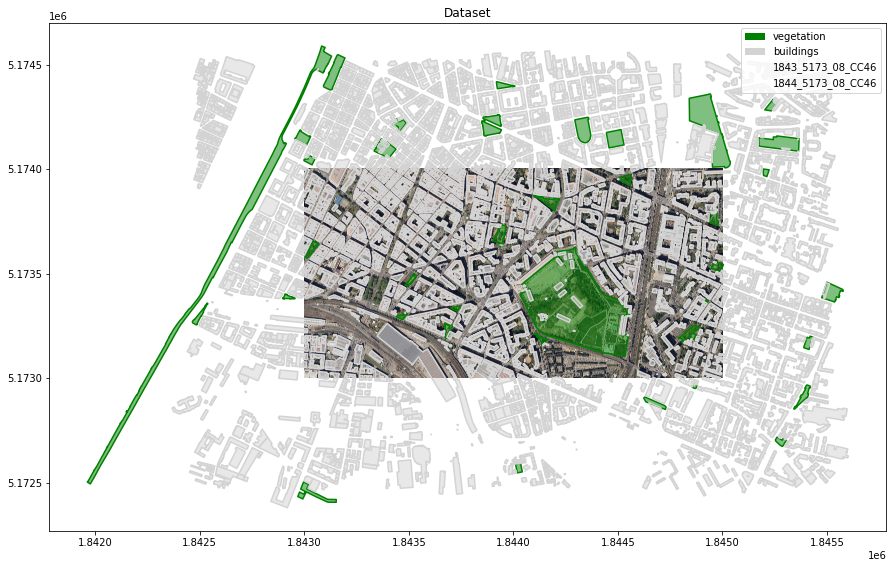

In [71]:
dataset.plot(figsize=(15, 15))

## Generate labels

Labels are rasterized categories. The color used are the categories' ones.  
Generate the labels with the method ``generate_labels``.

In [72]:
dataset.generate_labels()

INFO: Generating labels at 'data\labels'.
Generating Labels: 100%|████████████████████████████████████████████████████████████████| 2/2 [04:12<00:00, 126.03s/it]


'data\\labels'

The labels should look like:

![labels](https://raw.githubusercontent.com/makinacorpus/geolabel-maker/projinfo-dev/notebooks/medias/lyon_labels.png)

### Generate mosaics

Then, you can split the images and labels into smaller rasters. You can either create tiles or mosaics but note that the tiles generation is slow.   
To generate mosaics, use the ``generate_mosaics`` method.

In [73]:
dataset.generate_mosaics(zoom=18, width=500, height=500)

INFO: Generating image mosaics at 'data\mosaics\images\18'.
Generating Mosaics: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.14it/s]
INFO: Generating labels mosaics at 'data\mosaics\labels\18'.
Generating Mosaics: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.51it/s]


'data\\mosaics'

The mosaics should look like this (original resolution and zoom 18):

![mosaics](https://raw.githubusercontent.com/makinacorpus/geolabel-maker/projinfo-dev/notebooks/medias/lyon_mosaics.png)

### Generate tiles

The tiles generation requires ``gdal2tiles``.   
To generate tiles, use the ``generate_tiles`` method. As this method can takes hours (or days !), we will not run it in this notebook.

```python
dataset.generate_tiles(zoom="18")
```

### Configuration

As we said previously, the ``Dataset`` uses a configuration file to keep track of the process.  
Because we generated labels and mosaics (or tiles), the configuration was updated under the hood:

In [74]:
with open(dataset.filename, "r") as f:
    config = json.load(f)
    
config

{'images': [{'id': 0, 'filename': 'images\\1843_5173_08_CC46.tif'},
  {'id': 1, 'filename': 'images\\1844_5173_08_CC46.tif'}],
 'categories': [{'id': 0,
   'name': 'vegetation',
   'color': [0, 128, 0],
   'filename': 'categories\\vegetation.json'},
  {'id': 1,
   'name': 'buildings',
   'color': [211, 211, 211],
   'filename': 'categories\\buildings.json'}],
 'dir_labels': 'labels',
 'labels': [{'id': 0, 'filename': '1843_5173_08_CC46-label.tif'},
  {'id': 1, 'filename': '1844_5173_08_CC46-label.tif'}],
 'dir_mosaics': 'mosaics'}

Now, we have new fields that track labels and mosaics / tiles.

## Generate annotations

To build the annotations, we must provide couples of images and labels. Any kind of rasters are accepted. For example, we can use the sub-images we generated (at zoom 17) to generate the annotations.

Multiple formats are available: 
- **`Classification`**: annotations for image classification.
- **`ObjectDetection`**: annotations used to localize (from a bounding box) objects in images,
- **`Segmentation`**: annotations used for instance segmentation,

For all of them, you can choose between two generation processes. 
- **`build`**: generates annotations from images and labels (masks). You also need to provide colors or categories. Although this method is fast, its precision depends on the resolution of the labels.
- **`make`**: generate annotations from scratch. All instances of the objects will be kept, therefore this method does not depends on the resolution of the images. Because the process uses directly the categories and geometries (as opposed to the masks used for `build`), this method is slower.

### Generate Segmentation annotations

Segmentation annotations, in [COCO](http://cocodataset.org/) format, are used to extract geometries of the objects in images.

#### Build annotations

The `build` method is a fast generation of annotations from images and labels / masks. You can provide multiple arguments as long as there are images and labels associated to their categories / colors.

- `dir_images` (str): load images from a directory;
- `dir_labels` (str): load labels / masks from a directory;
- `images` (list or collection): provide images as a list;
- `labels` (list or collection): provide labels / masks as a list;
- `categories` (list or collection): provide colors from categories (note that only the color and name from the categories will be used);
- `colors` (dict): provide directly the colors associated to the categories as a dict.

In [94]:
segmentation = Segmentation.build(
    dir_images = "data/mosaics/images/18",
    dir_labels = "data/mosaics/labels/18",
    # images = [list of your images],
    # labels = [list of your labels associated to the above images],
    colors = {"buildings": "#92a9a2", "vegetation": "green"}
    # categories = dataset.categories
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.25it/s]


Once finished, you can visualize the segmentation map with `plot` method.
To visualize a specific image, provide the argument `image_id` corresponding the id of the image you wish to plot.
Additionally, you can customize the colors and opacity.

<AxesSubplot:title={'center':'image_id n°7'}>

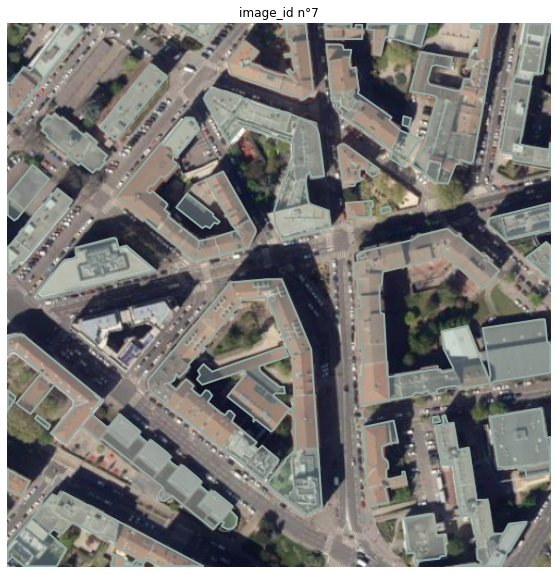

In [95]:
segmentation.plot(figsize=(10, 10), colors={"buildings": "#92a9a2", "vegetation": "green"})

<AxesSubplot:title={'center':'image_id n°12'}>

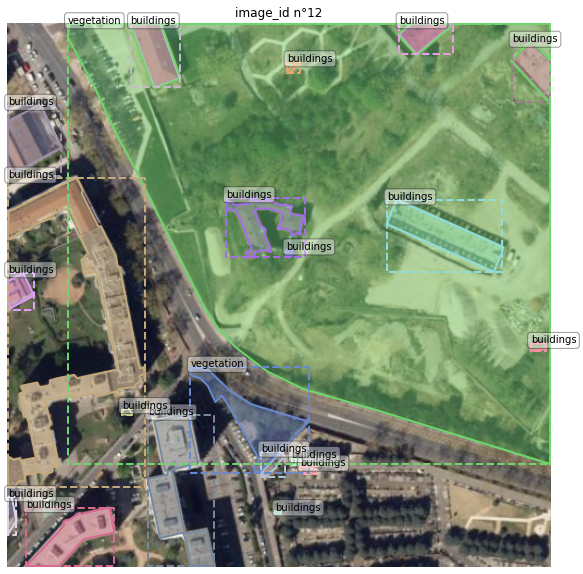

In [96]:
segmentation.plot(figsize=(10, 10), plot_bbox=True, plot_name=True)

You should note that the quality of the segmentation does not correctly follows the structure of the buildings. This is because the polygons were retrieved from the label images and not the categories.

#### Make annotations

The ``make`` method will create annotations directly from the categories.
You can provide multiple arguments, as long as there are images and categories.

- `dir_images` (str): load images from a directory;
- `dir_categories` (str): load categories from a directory;
- `images` (list or collection): provide images as a list;
- `categories` (list or collection): provide categories as a list.

In [78]:
segmentation = Segmentation.make(
    dir_images = "data/mosaics/images/18",
    # dir_categories = "path/to/your/categories",
    # images = [list of your images],
    categories = dataset.categories
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 18/18 [01:30<00:00,  5.00s/it]


<AxesSubplot:title={'center':'image_id n°7'}>

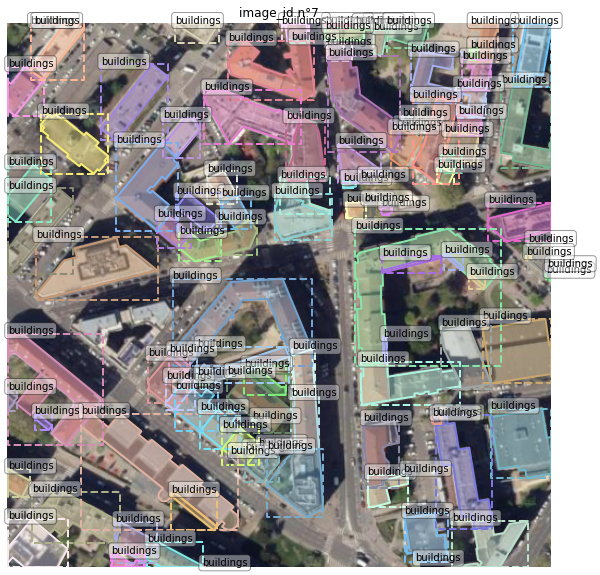

In [79]:
segmentation.plot(figsize=(10, 10), plot_bbox=True, plot_name=True)

Because the geometries from the categories were used to retrieve polygons on the images, the segmentation map follows exactly the semantic information.

In [80]:
segmentation.save("segmentation.json")

### Generate object detection annotations

Object detection annotations are used to know the location of an object (a.k.a. bounding box) in an image.
The most used bounding box for object detection is in $(x_{\text{min}}, y_{\text{min}}, \text{width}, \text{height})$ format.

#### Build annotations

The `build` method is a fast generation of annotations from images and labels / masks. You can provide multiple arguments as long as there are images and labels associated to their categories / colors.

- `dir_images` (str): load images from a directory;
- `dir_labels` (str): load labels / masks from a directory;
- `images` (list or collection): provide images as a list;
- `labels` (list or collection): provide labels / masks as a list;
- `categories` (list or collection): provide colors from categories (note that only the color and name from the categories will be used);
- `colors` (dict): provide directly the colors associated to the categories as a dict.

In [81]:
objects = ObjectDetection.build(
    dir_images = "data/mosaics/images/18",
    dir_labels = "data/mosaics/labels/18",
    # images = [list of your images],
    # labels = [list of your labels associated to the above images],
    colors = {"buildings": "#92a9a2", "vegetation": "green"}
    # categories = dataset.categories
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.09it/s]


Once finished, you can visualize the segmentation map with `plot` method.
To visualize a specific image, provide the argument `image_id` corresponding the id of the image you wish to plot.
Additionally, you can customize the colors and opacity.

<AxesSubplot:title={'center':'image_id n°4'}>

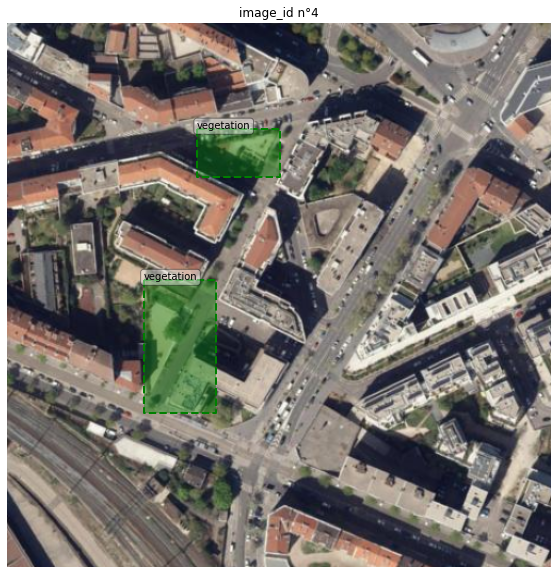

In [82]:
objects.plot(image_id=4, colors={"buildings": "#92a9a2", "vegetation": "green"}, plot_name=True, figsize=(10, 10))

#### Make annotations

The ``make`` method will create annotations directly from the categories.
You can provide multiple arguments, as long as there are images and categories.

- `dir_images` (str): load images from a directory;
- `dir_categories` (str): load categories from a directory;
- `images` (list or collection): provide images as a list;
- `categories` (list or collection): provide categories as a list.

In [83]:
objects = ObjectDetection.make(
    dir_images = "data/mosaics/images/18",
    # dir_categories = "path/to/your/categories",
    # images = [list of your images],
    categories = dataset.categories
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 18/18 [01:27<00:00,  4.86s/it]


<AxesSubplot:title={'center':'image_id n°3'}>

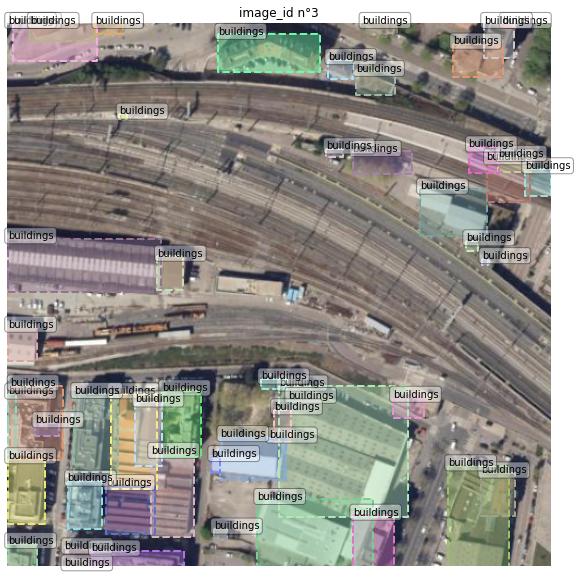

In [84]:
objects.plot(image_id=3, figsize=(10, 10), plot_name=True)

Because the geometries from the categories were used to retrieve polygons on the images, the segmentation map follows exactly the semantic information.

In [85]:
objects.save("objects.json")

### Generate classification annotations

The classification annotations is a table linking providing information on the categories seen by each image.

#### Build annotations

The `build` method is a fast generation of annotations from images and labels / masks. You can provide multiple arguments as long as there are images and labels associated to their categories / colors.

- `dir_images` (str): load images from a directory;
- `dir_labels` (str): load labels / masks from a directory;
- `images` (list or collection): provide images as a list;
- `labels` (list or collection): provide labels / masks as a list;
- `categories` (list or collection): provide colors from categories (note that only the color and name from the categories will be used);
- `colors` (dict): provide directly the colors associated to the categories as a dict.

In [86]:
classif = Classification.build(
    dir_images = "data/mosaics/images/18",
    dir_labels = "data/mosaics/labels/18",
    # images = [list of your images],
    # labels = [list of your labels associated to the above images],
    colors = {"buildings": "#92a9a2", "vegetation": "green"}
    # categories = dataset.categories
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 53.33it/s]


Once finished, you can visualize the segmentation map with `plot` method.
To visualize a specific image, provide the argument `image_id` corresponding the id of the image you wish to plot.
Additionally, you can customize the colors and opacity.

<AxesSubplot:title={'center':'image_id n°4'}>

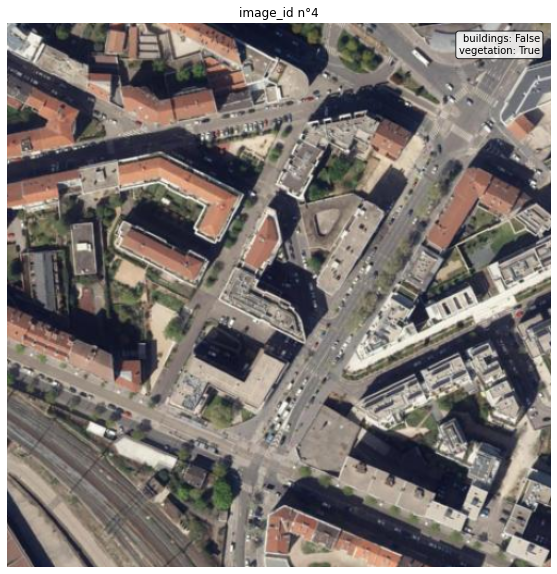

In [87]:
classif.plot(image_id=4, figsize=(10, 10))

In [88]:
classif = Classification.make(
    dir_images = "data/mosaics/images/18",
    # dir_categories = "path/to/your/categories",
    # images = [list of your images],
    categories = dataset.categories
)

Build Annotations: 100%|███████████████████████████████████████████████████████████████| 18/18 [01:25<00:00,  4.74s/it]


#### Make annotations

The ``make`` method will create annotations directly from the categories.
You can provide multiple arguments, as long as there are images and categories.

- `dir_images` (str): load images from a directory;
- `dir_categories` (str): load categories from a directory;
- `images` (list or collection): provide images as a list;
- `categories` (list or collection): provide categories as a list.

<AxesSubplot:title={'center':'image_id n°6'}>

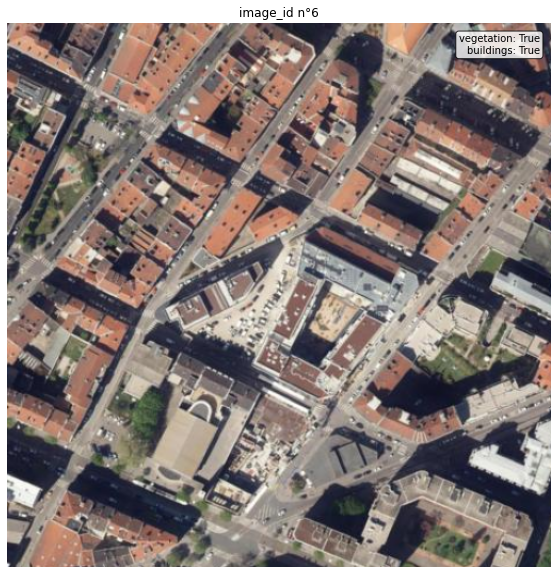

In [89]:
classif.plot(figsize=(10, 10))

In [90]:
classif.save("classification.txt")

### Open your annotations

Last but not least, you can open your saved annotations with the `open` class method.

In [91]:
segmentation = Segmentation.open("segmentation.json")
print(segmentation)

objects = ObjectDetection.open("objects.json")
print(objects)

classif = Classification.open("classification.txt")
print(classif)

Segmentation(images=18, categories=2, annotations=1901)
ObjectDetection(images=18, categories=2, annotations=1901)
Classification(images=18, categories=2, annotations=18)


...and visualize the annotations.

<AxesSubplot:title={'center':'image_id n°5'}>

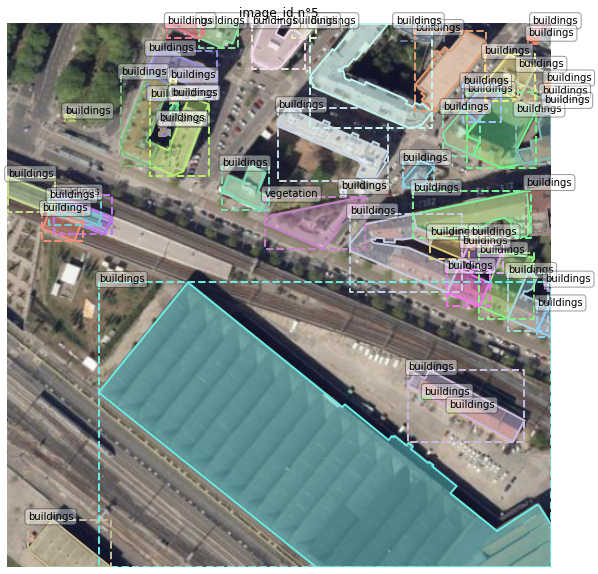

In [92]:
segmentation.plot(figsize=(10, 10), plot_bbox=True, plot_name=True)

If you are interested in an in-depth look of this package, you can check the next notebook: [Advanced data manipulation with Geolabel Maker]().

We also provide a small tutorial to visualize your annotations with `pycocotools` [Check COCO annotations with pycocotools]().